In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE=(224,224)

In [3]:
import pathlib
data_dir=pathlib.Path("/home/sanjana/Desktop/medical_imaging/cervical-cancer")
data_dir

PosixPath('/home/sanjana/Desktop/medical_imaging/cervical-cancer')

In [4]:
image_count=len(list(data_dir.glob('*/*jpg')))
image_count

962

In [5]:
lesions_dict={
    'NILM': list(data_dir.glob('NILM/*')),
    'LSIL': list(data_dir.glob('LSIL/*')),
    'HSIL': list(data_dir.glob('HSIL/*')),
    'SCC': list(data_dir.glob('SCC/*')),
}

In [6]:
lesions_labels={
    'NILM': 0,
    'LSIL': 1,
    'HSIL': 2,
    'SCC': 3,
}

In [7]:
x, y=[],[]
for lesions_name, images in lesions_dict.items():
    for image in images:
        img=cv2.imread(str(image))
        x.append(img)
        y.append(lesions_labels[lesions_name])

In [8]:
x=np.array(x)
y=np.array(y)

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [10]:
x_train_scaled=x_train/255
x_test_scaled=x_test/255
x_val_scaled=x_val/255
print(len(x_train_scaled))
print(len(x_val_scaled))
print(len(x_test_scaled))

576
193
193


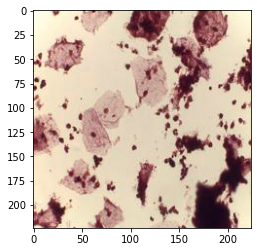

In [11]:
plt.imshow(x[191])

In [12]:
classifier="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
mod=hub.KerasLayer(classifier, input_shape=(224,224,3), trainable=False)

In [13]:
data_aug=keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [14]:
num_lesions=4
model=tf.keras.Sequential([
    data_aug,
    mod, 
    tf.keras.layers.Dense(2048, activation="relu"),
    tf.keras.layers.Dense(1024, activation="relu"), #512, 256
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_lesions)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
dense (Dense)                (None, 2048)              2052096   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                

In [15]:
import matplotlib.pyplot as plt

model.compile(
    optimizer="adam", 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

history = model.fit(x_train_scaled, y_train, validation_data=(x_val_scaled, y_val), batch_size=20,epochs=10)
print(history.history.keys())


Epoch 1/10
29/29 [==============================] - 21s 592ms/step - loss: 0.7896 - acc: 0.7569 - val_loss: 0.6385 - val_acc: 0.7668
Epoch 2/10
29/29 [==============================] - 16s 546ms/step - loss: 0.2442 - acc: 0.8976 - val_loss: 0.1951 - val_acc: 0.9171
Epoch 3/10
29/29 [==============================] - 17s 592ms/step - loss: 0.1050 - acc: 0.9583 - val_loss: 0.2876 - val_acc: 0.9067
Epoch 4/10
29/29 [==============================] - 15s 512ms/step - loss: 0.1191 - acc: 0.9479 - val_loss: 0.3945 - val_acc: 0.8653
Epoch 5/10
29/29 [==============================] - 16s 544ms/step - loss: 0.1509 - acc: 0.9531 - val_loss: 0.4255 - val_acc: 0.8446
Epoch 6/10
29/29 [==============================] - 16s 549ms/step - loss: 0.0542 - acc: 0.9774 - val_loss: 0.6438 - val_acc: 0.8808
Epoch 7/10
29/29 [==============================] - 16s 551ms/step - loss: 0.0911 - acc: 0.9705 - val_loss: 0.5499 - val_acc: 0.8549
Epoch 8/10
29/29 [==============================] - 16s 559ms/step - 

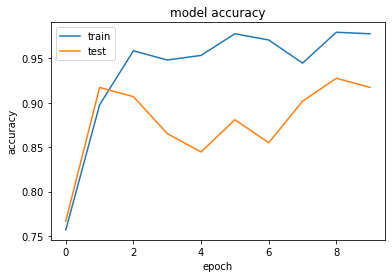

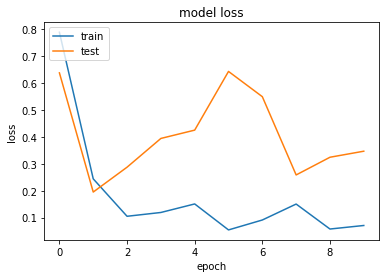

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
model.evaluate(x_test_scaled, y_test)

7/7 [==============================] - 2s 338ms/step - loss: 0.3912 - acc: 0.9119


[0.3911586105823517, 0.9119170904159546]

In [18]:
preds=model.predict(x_test_scaled)

In [19]:
pred_classes=np.argmax(preds, axis=1)

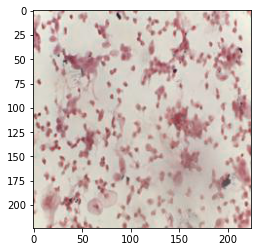

In [20]:
plt.imshow(x_test_scaled[3])

In [21]:
pred_classes

array([0, 1, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 1, 3, 2, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 3, 2, 2, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 1, 0, 3, 0, 2, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 1, 0, 3, 0, 1,
       0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 3, 1, 0, 0, 1, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 3, 1])

In [22]:

class_labels=[0,1,2,3]

In [23]:
import sklearn.metrics as metrics
report = metrics.classification_report(y_test, pred_classes, class_labels)
print(report) 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       128
           1       0.69      1.00      0.82        20
           2       0.94      0.48      0.64        31
           3       0.72      0.93      0.81        14

    accuracy                           0.91       193
   macro avg       0.83      0.85      0.81       193
weighted avg       0.93      0.91      0.90       193



/home/sanjana/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_classes)

array([[128,   0,   0,   0],
       [  0,  20,   0,   0],
       [  2,   9,  15,   5],
       [  0,   0,   1,  13]])

TypeError: Cannot clone object '<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f24a4406470>' (type <class 'tensorflow.python.keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.